In [1]:
import numpy as np
import qiskit
import qiskit_ibm_runtime
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.datasets import ad_hoc_data

In [2]:
from qiskit_aer import AerSimulator
sim = AerSimulator()

# Ad Hoc Data

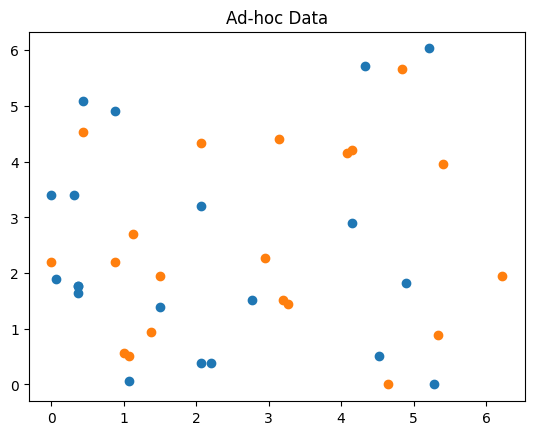

In [3]:
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=20,
    n=2,
    gap=0.3,
    plot_data=True,
    one_hot=False,
    include_sample_total=True,
)
train_labels = np.where(train_labels == 0, -1, 1)
test_labels = np.where(test_labels == 0, -1, 1)

# Feature Map

$$
Z = \left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right)
\qquad
Z_0Z_1 = \left(\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1
\end{array}\right)
$$

$$U_{\Phi(\vec{x})}=\exp \left(i [x_1 Z_1+x_2 Z_2+(\pi-x_1)(\pi-x_2) Z_1Z_2]\right)=\exp \left(i x_1 Z_1\right)*\exp \left(i x_2 Z_2\right)*\exp \left(i (\pi-x_1)(\pi-x_2) Z_1Z_2\right)$$

$$P(\lambda)=\left(\begin{array}{cc}
1 & 0 \\
0 & e^{i \lambda}
\end{array}\right)
\qquad 
P(-2\lambda)=\left(\begin{array}{cc}
1 & 0 \\
0 & e^{-i 2\lambda}
\end{array}\right)
=e^{-i \lambda}*\left(\begin{array}{cc}
e^{i \lambda} & 0 \\
0 & e^{-i \lambda}
\end{array}\right)
$$

$$
 \exp \left(i x_0 Z_0\right) = \left(\begin{array}{cc}
e^{i x_0} & 0 \\
0 & e^{-i x_0}
\end{array}\right)
= e^{i x_0}*P(-2x_0)
\qquad \exp \left(i x_1 Z_1\right) = \left(\begin{array}{cc}
e^{i x_1} & 0 \\
0 & e^{-i x_1}
\end{array}\right)
= e^{i x_1}*P(-2x_1)
$$

$$Z_0Z_1 = \left(\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1
\end{array}\right)
\qquad
e^{i \lambda Z_0 Z_1}=\left(\begin{array}{cccc}
e^{i \lambda} & 0 & 0 & 0 \\
0 & e^{-i \lambda} & 0 & 0 \\
0 & 0 & e^{-i \lambda} & 0 \\
0 & 0 & 0 & e^{i \lambda}
\end{array}\right)=e^{-i \lambda}*\left(\begin{array}{cc}
P(-2\lambda) & 0 \\
0 & X P(-2\lambda) X
\end{array}\right)
= e^{-i \lambda}* [C X \cdot(I \otimes P(-2\lambda)) \cdot C X]
$$

$$\text { since } X P(-2\lambda) X=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right)\left(\begin{array}{cc}
e^{i \lambda} & 0 \\
0 & e^{-i \lambda}
\end{array}\right)\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right)=\left(\begin{array}{cc}
e^{-i \lambda} & 0 \\
0 & e^{i \lambda}
\end{array}\right)
$$

In [4]:
def feature_map_custom(fm, x):
    fm.h(0)
    fm.h(1)
    fm.barrier()
    fm.p(-2*x[0], 0)
    fm.p(-2*x[1], 1)
    fm.cx(0, 1)
    fm.p(-2*(np.pi-x[0])*(np.pi-x[1]), 1)
    fm.cx(0, 1)
    fm.barrier()
    fm.h(0)
    fm.h(1)
    fm.barrier()
    fm.p(-2*x[0], 0)
    fm.p(-2*x[1], 1)
    fm.cx(0, 1)
    fm.p(-2*(np.pi-x[0])*(np.pi-x[1]), 1)
    fm.cx(0, 1)

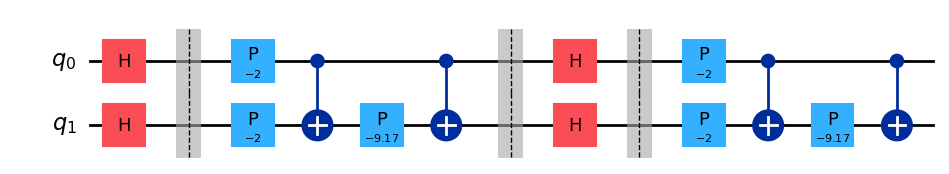

In [5]:
fm = QuantumCircuit(2)
feature_map_custom(fm, [1.0, 1.0])
fm.decompose("U_phi").draw(output='mpl')

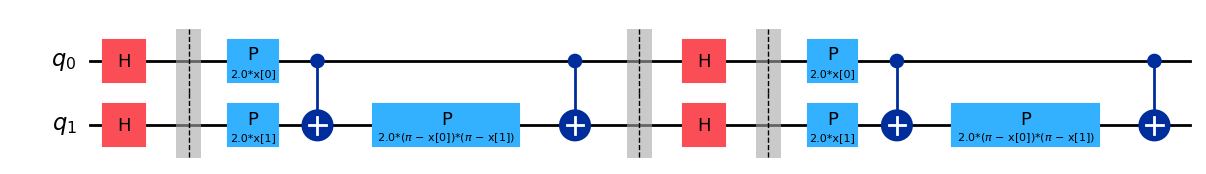

In [6]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, insert_barriers=True, entanglement = 'full')
feature_map.decompose().draw(output='mpl')

In [7]:
for gate in feature_map.decompose().data:
    print('\ngate name:', gate[0].name)
    print('qubit(s) acted on:', gate[1])
    print('other paramters (such as angles):', gate[0].params)


gate name: h
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 0)]
other paramters (such as angles): []

gate name: h
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 1)]
other paramters (such as angles): []

gate name: barrier
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)]
other paramters (such as angles): []

gate name: p
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 0)]
other paramters (such as angles): [ParameterExpression(2.0*x[0])]

gate name: p
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 1)]
other paramters (such as angles): [ParameterExpression(2.0*x[1])]

gate name: cx
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)]
other paramters (such as angles): []

gate name: p
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 1)]
other paramters (such as angles): [ParameterExpression(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1]))]

gate name: cx
qubit(s) acted on: [Qubit(Quantu

# Ansatz

$$W(\vec{\theta})=U_{\mathrm{loc}}^{(l)}\left(\theta_l\right) U_{\mathrm{ent}} \ldots U_{\mathrm{loc}}^{(2)}\left(\theta_2\right) U_{\mathrm{ent}} U_{\mathrm{loc}}^{(1)}\left(\theta_1\right) $$

$$U_{\text {loc }}^{(t)}\left(\theta_t\right)=\otimes_{m=1}^n U\left(\theta_{m, t}\right) \qquad U\left(\theta_{m, t}\right)=e^{i \frac{1}{2} \theta_{m, t}^z Z_m} e^{i \frac{1}{2} \theta_{m, t}^y Y_m}$$

$$U_{\mathrm{ent}}=\prod_{(i, j) \in E} \mathrm{CZ}(i, j)$$

$$R Y(\theta)=\exp \left(-i \frac{\theta}{2} Y\right)=\left(\begin{array}{cc}
\cos \left(\frac{\theta}{2}\right) & -\sin \left(\frac{\theta}{2}\right) \\
\sin \left(\frac{\theta}{2}\right) & \cos \left(\frac{\theta}{2}\right)
\end{array}\right)$$

$$R Z(\lambda)=\exp \left(-i \frac{\lambda}{2} Z\right)=\left(\begin{array}{cc}
e^{-i \frac{\lambda}{2}} & 0 \\
0 & e^{i \frac{\lambda}{2}}
\end{array}\right)$$

In [8]:
def ansatz_custom(ansatz, theta, reps=1):
    for i in range(reps+1):
        if i!=0 & i!=reps:
            ansatz.cz(0, 1)
        ansatz.ry(theta[0+4*i], 0)
        ansatz.ry(theta[1+4*i], 1)
        ansatz.rz(theta[2+4*i], 0)
        ansatz.rz(theta[3+4*i], 1)

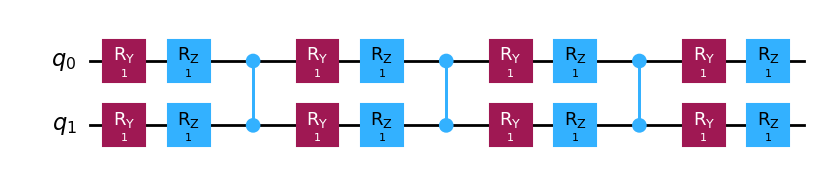

In [9]:
ansatz = QuantumCircuit(2)
ansatz_custom(ansatz, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 3)
ansatz.draw(output='mpl')

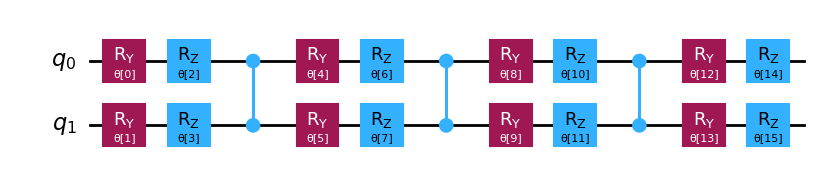

In [10]:
var_form = TwoLocal(2, ['ry', 'rz'], 'cz', reps=3)
var_form.decompose().draw(output='mpl')

In [11]:
for gate in var_form.decompose().data:
    print('\ngate name:', gate[0].name)
    print('qubit(s) acted on:', gate[1])
    print('other paramters (such as angles):', gate[0].params)


gate name: ry
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 0)]
other paramters (such as angles): [ParameterVectorElement(θ[0])]

gate name: rz
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 0)]
other paramters (such as angles): [ParameterVectorElement(θ[2])]

gate name: ry
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 1)]
other paramters (such as angles): [ParameterVectorElement(θ[1])]

gate name: rz
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 1)]
other paramters (such as angles): [ParameterVectorElement(θ[3])]

gate name: cz
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)]
other paramters (such as angles): []

gate name: ry
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 0)]
other paramters (such as angles): [ParameterVectorElement(θ[4])]

gate name: rz
qubit(s) acted on: [Qubit(QuantumRegister(2, 'q'), 0)]
other paramters (such as angles): [ParameterVectorElement(θ[6])]

gate name: ry
qubit(s) acted on: [Qubit(Quantum

In [12]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [13]:
def single_circuit_evaluation(x, theta, reps=3, shots=4000):
    qc = QuantumCircuit(2)
    feature_map_custom(qc, x)
    ansatz_custom(qc, theta, reps)
    qc.z(0)
    qc.z(1)
    qc.measure_all()
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    return counts

In [14]:
x = [1.0, 1.0]
theta = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
counts = single_circuit_evaluation(x, theta)
print(counts)

{'00': 1800, '11': 387, '10': 955, '01': 858}


In [15]:
def training_phase(train_features, train_labels, shots=2000):
    r = shots/10
    converged = False
    theta = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    empirical_risk = 0
    py_empirical = 0
    y = 0
    b = 0
    
    while not converged:
        empirical_risk = 0
        for i in len(train_features):
            counts = single_circuit_evaluation(train_features[i], theta, 3, shots)
            p_0 = (counts['00']+counts['11'])/shots
            p_1 = (counts['01']+counts['10'])/shots
            if train_labels[i] == 1:
                py_empirical = p_1
                y = 1
            else:
                py_empirical = p_0
                y = -1
            top = np.sqrt(r)*(0.5-(py_empirical-0.5*(y*b)))
            bottom = np.sqrt(2*(1-py_empirical)*py_empirical)
            empirical_risk += sigmoid(top/bottom)   
        empirical_risk /= len(train_features)
